In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from fbprophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
folderName  = "/gdrive/My Drive/colab/Sale_data/dataset"
fileName = "scm_total.csv"
dataSource = folderName + "/" + fileName
print(dataSource)

/gdrive/My Drive/colab/Sale_data/dataset/scm_total.csv


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df = pd.read_csv(dataSource)
df = reduce_mem_usage(df)

Mem. usage decreased to  0.54 Mb (20.8% reduction)


In [6]:
print('-'*60)
print('*** Head of the dataframe ***')
print('-'*60)
print(df.head())
print('-'*60)
print('*** Tail of the dataframe ***')
print('-'*60)
print(df.tail())

------------------------------------------------------------
*** Head of the dataframe ***
------------------------------------------------------------
   days_ap_kor_amt  ...                      ap_date
0     -27358531452  ...  2012-12-21T00:00:00.0000000
1      -4074817040  ...  2013-04-17T00:00:00.0000000
2       -850560000  ...  2012-05-10T00:00:00.0000000
3         -3293983  ...  2018-09-20T00:00:00.0000000
4             5000  ...  2014-12-02T00:00:00.0000000

[5 rows x 6 columns]
------------------------------------------------------------
*** Tail of the dataframe ***
------------------------------------------------------------
       days_ap_kor_amt  ...                      ap_date
14809      36708230616  ...  2010-12-31T00:00:00.0000000
14810      42936231808  ...  2011-05-30T00:00:00.0000000
14811      43031603851  ...  2011-04-30T00:00:00.0000000
14812      56837494896  ...  2011-06-30T00:00:00.0000000
14813      83627550672  ...  2011-08-25T00:00:00.0000000

[5 rows x 6 c

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14814 entries, 0 to 14813
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   days_ap_kor_amt     14814 non-null  int64 
 1   days_unit_ap_qty    14814 non-null  int32 
 2   days_unit_price     14814 non-null  int64 
 3   incremental_number  14814 non-null  int16 
 4   org_display         14814 non-null  object
 5   ap_date             14814 non-null  object
dtypes: int16(1), int32(1), int64(2), object(2)
memory usage: 549.9+ KB


In [8]:
df.head()

,days_ap_kor_amt,days_unit_ap_qty,days_unit_price,incremental_number,org_display,ap_date
0,-27358531452,445626,1075281566,1589,Gunsan RE,2012-12-21T00:00:00.0000000
1,-4074817040,1941,45544429355,13799,Gunsan RE,2013-04-17T00:00:00.0000000
2,-850560000,-199000,38643,7482,Gunsan RE,2012-05-10T00:00:00.0000000
3,-3293983,-1700,1,3536,Gunsan Chemical,2018-09-20T00:00:00.0000000
4,5000,2,2500,10106,Iksan VIP,2014-12-02T00:00:00.0000000


In [9]:
df["timestamp"] = pd.to_datetime(df["ap_date"])
df["Date"] = pd.to_datetime(df["ap_date"])
df.set_index("timestamp", inplace=True)
df.head()

,days_ap_kor_amt,days_unit_ap_qty,days_unit_price,incremental_number,org_display,ap_date,Date
timestamp,,,,,,,
2012-12-21,-27358531452,445626,1075281566,1589,Gunsan RE,2012-12-21T00:00:00.0000000,2012-12-21
2013-04-17,-4074817040,1941,45544429355,13799,Gunsan RE,2013-04-17T00:00:00.0000000,2013-04-17
2012-05-10,-850560000,-199000,38643,7482,Gunsan RE,2012-05-10T00:00:00.0000000,2012-05-10
2018-09-20,-3293983,-1700,1,3536,Gunsan Chemical,2018-09-20T00:00:00.0000000,2018-09-20
2014-12-02,5000,2,2500,10106,Iksan VIP,2014-12-02T00:00:00.0000000,2014-12-02


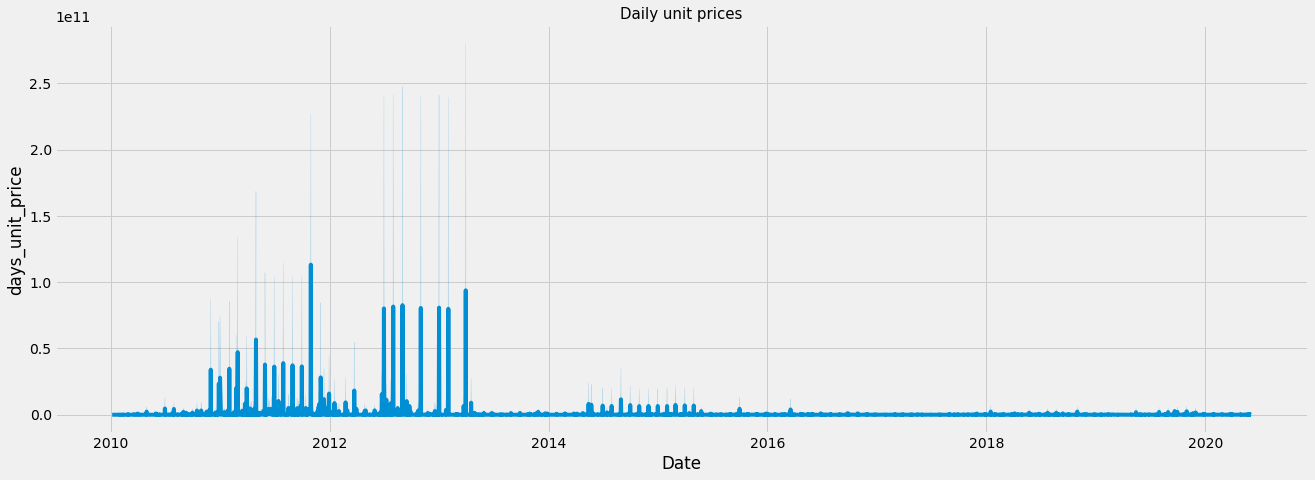

In [10]:
fig, ax = plt.subplots(figsize=(20, 7))
a = sns.lineplot(x="Date", y="days_unit_price", data=df)
a.set_title("Daily unit prices", fontsize=15)
plt.show()

## 1. Month 기준

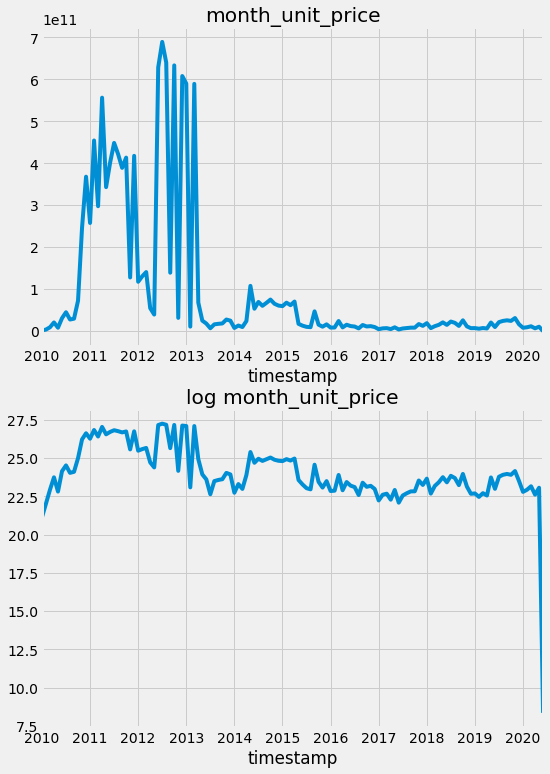

In [11]:
df_month = df.resample("M").sum()

fig, ax = plt.subplots(2, 1, figsize=(10, 3))
fig.set_size_inches(8,12)

df_month["days_unit_price"].plot.line(ax=ax[0])
np.log(df_month["days_unit_price"]).plot.line(ax=ax[1])
ax[0].set_title("month_unit_price")
ax[1].set_title("log month_unit_price")
plt.show()

skew of month_days_unit_price:  2.15422402066921
kurtosis of month_days_unit_price :  3.415613664183528


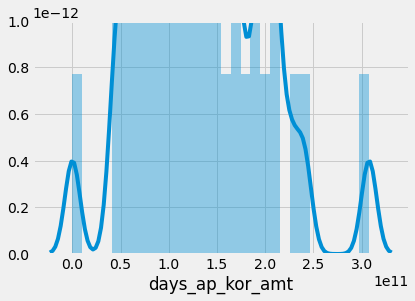

In [12]:
sns.distplot(df_month["days_ap_kor_amt"])
print("skew of month_days_unit_price: ", df_month["days_unit_price"].skew())
print("kurtosis of month_days_unit_price : ", df_month["days_unit_price"].kurtosis())

skew of log(days_unit_price): -3.3586580142204037
kurtosis of log(days_unit_price) :  27.6007848046707


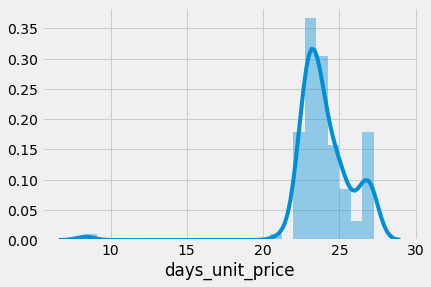

In [13]:
sns.distplot(np.log(df_month["days_unit_price"]))
print("skew of log(days_unit_price):", np.log(df_month["days_unit_price"]).skew())
print("kurtosis of log(days_unit_price) : ", np.log(df_month["days_unit_price"]).kurtosis())

## 2. Quarter 기준

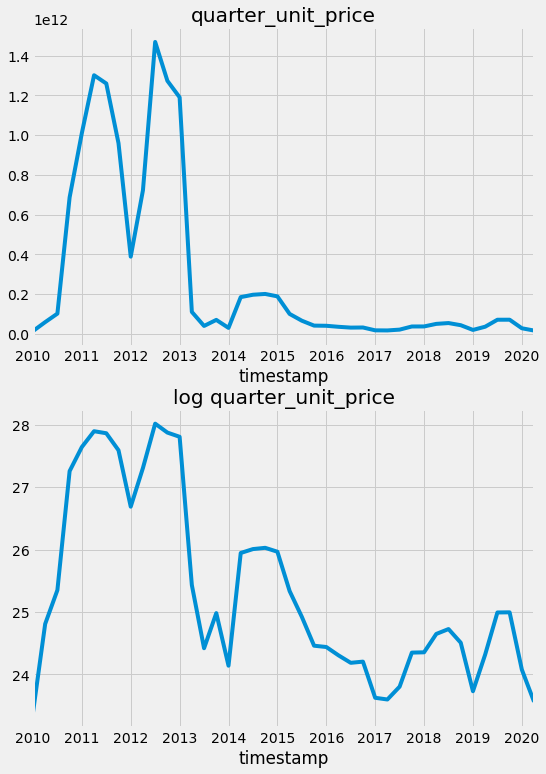

In [14]:
df_quarter = df.resample("Q").sum()

fig, ax = plt.subplots(2, 1, figsize=(10, 3))
fig.set_size_inches(8,12)

df_quarter["days_unit_price"].plot.line(ax=ax[0])
np.log(df_quarter["days_unit_price"]).plot.line(ax=ax[1])
ax[0].set_title("quarter_unit_price")
ax[1].set_title("log quarter_unit_price")
plt.show()

skew of month_days_unit_price:  1.6045170069425385
kurtosis of month_days_unit_price :  1.039966831100116


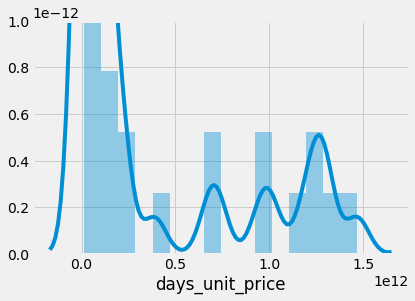

In [15]:
sns.distplot(df_quarter["days_unit_price"])
print("skew of month_days_unit_price: ", df_quarter["days_unit_price"].skew())
print("kurtosis of month_days_unit_price : ", df_quarter["days_unit_price"].kurtosis())

skew of log(days_unit_price): 0.7015112710919628
kurtosis of log(days_unit_price) :  -0.8506970182089386


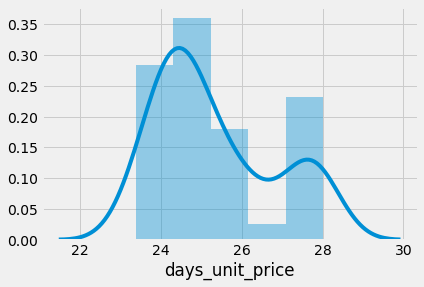

In [16]:
sns.distplot(np.log(df_quarter["days_unit_price"]))
print("skew of log(days_unit_price):", np.log(df_quarter["days_unit_price"]).skew())
print("kurtosis of log(days_unit_price) : ", np.log(df_quarter["days_unit_price"]).kurtosis())

## 1. 공장별 거래 transactions

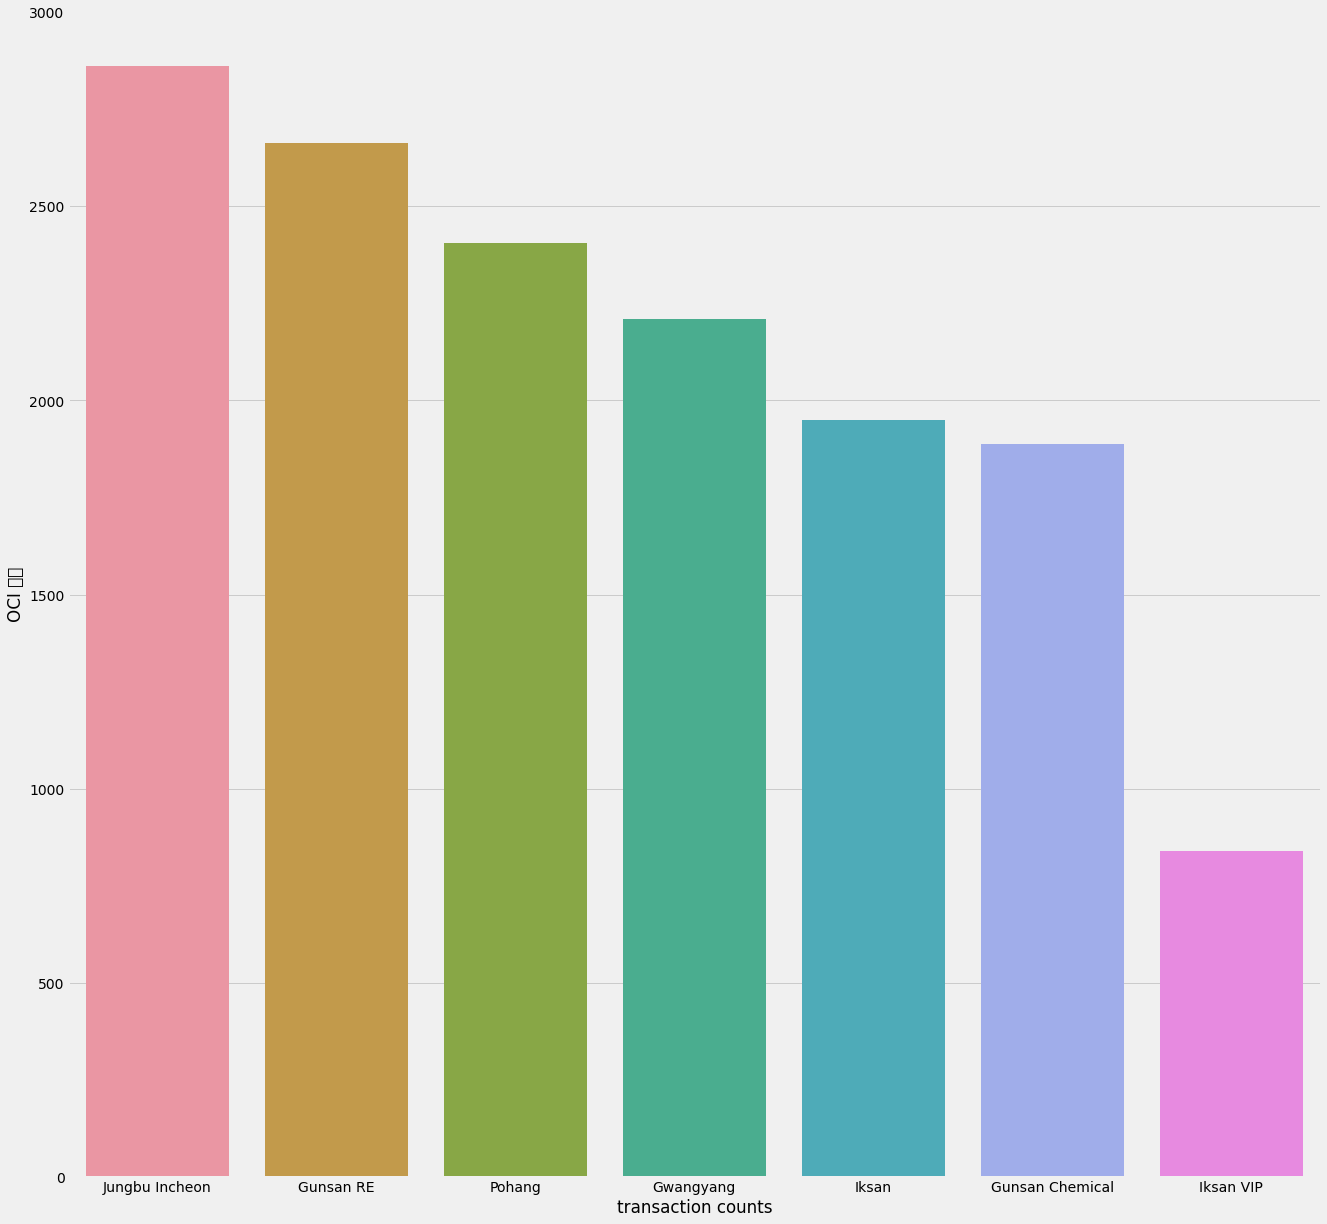

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
x = df["org_display"].value_counts().index.values
y = df["org_display"].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.xlabel("transaction counts")
plt.ylabel("OCI 공장")
plt.show()
# Iksan VIP의 경우 거래량이 상대적으로 적은 것을 알 수 있음

## 2. 공장별 unit_price의 총 합

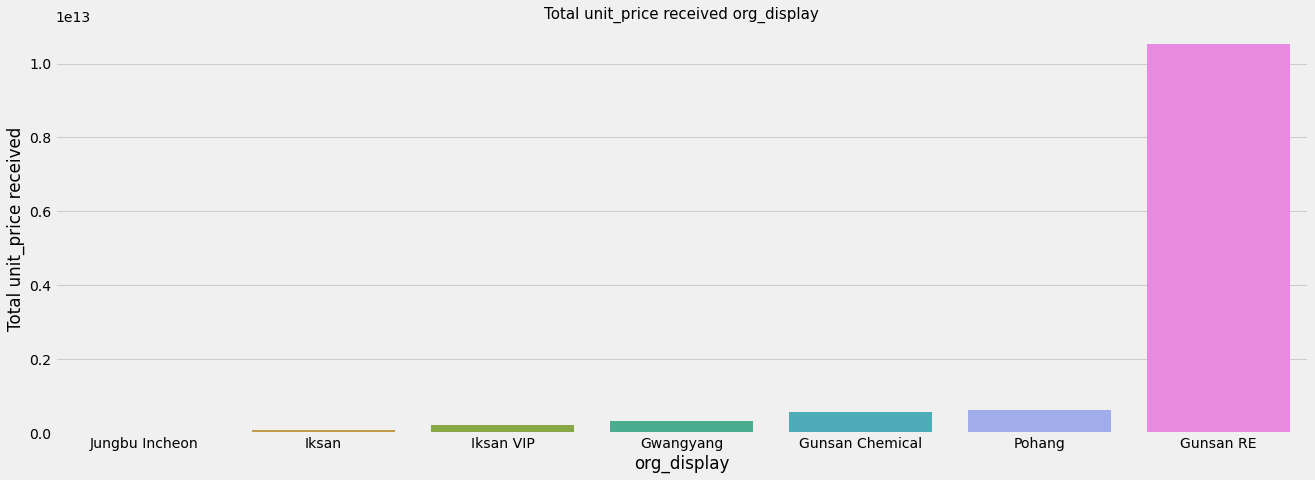

In [18]:
fig, ax = plt.subplots(figsize=(20, 7))
monthAggregated = pd.DataFrame(df.groupby("org_display")["days_unit_price"].sum()).reset_index().sort_values('days_unit_price')
sns.barplot(data=monthAggregated,x="org_display",y="days_unit_price",ax=ax)
ax.set(xlabel='org_display', ylabel='Total unit_price received')
ax.set_title("Total unit_price received org_display",fontsize=15)
plt.show()

## 3. 시간별 분석을 위한 utils

In [19]:
def date_features(df, label=None):
    df = df.copy()

    df['date'] = df.Date
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X
    
X, y = date_features(df, label='days_unit_price')
df_new = pd.concat([X, y], axis=1)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_unit_price
timestamp,,,,,,,,
2012-12-21,Friday,4,December,2012,356,21,51,1075281566
2013-04-17,Wednesday,2,April,2013,107,17,16,45544429355
2012-05-10,Thursday,2,May,2012,131,10,19,38643
2018-09-20,Thursday,3,September,2018,263,20,38,1
2014-12-02,Tuesday,4,December,2014,336,2,49,2500


## 5. 년도별 월별 unit_price

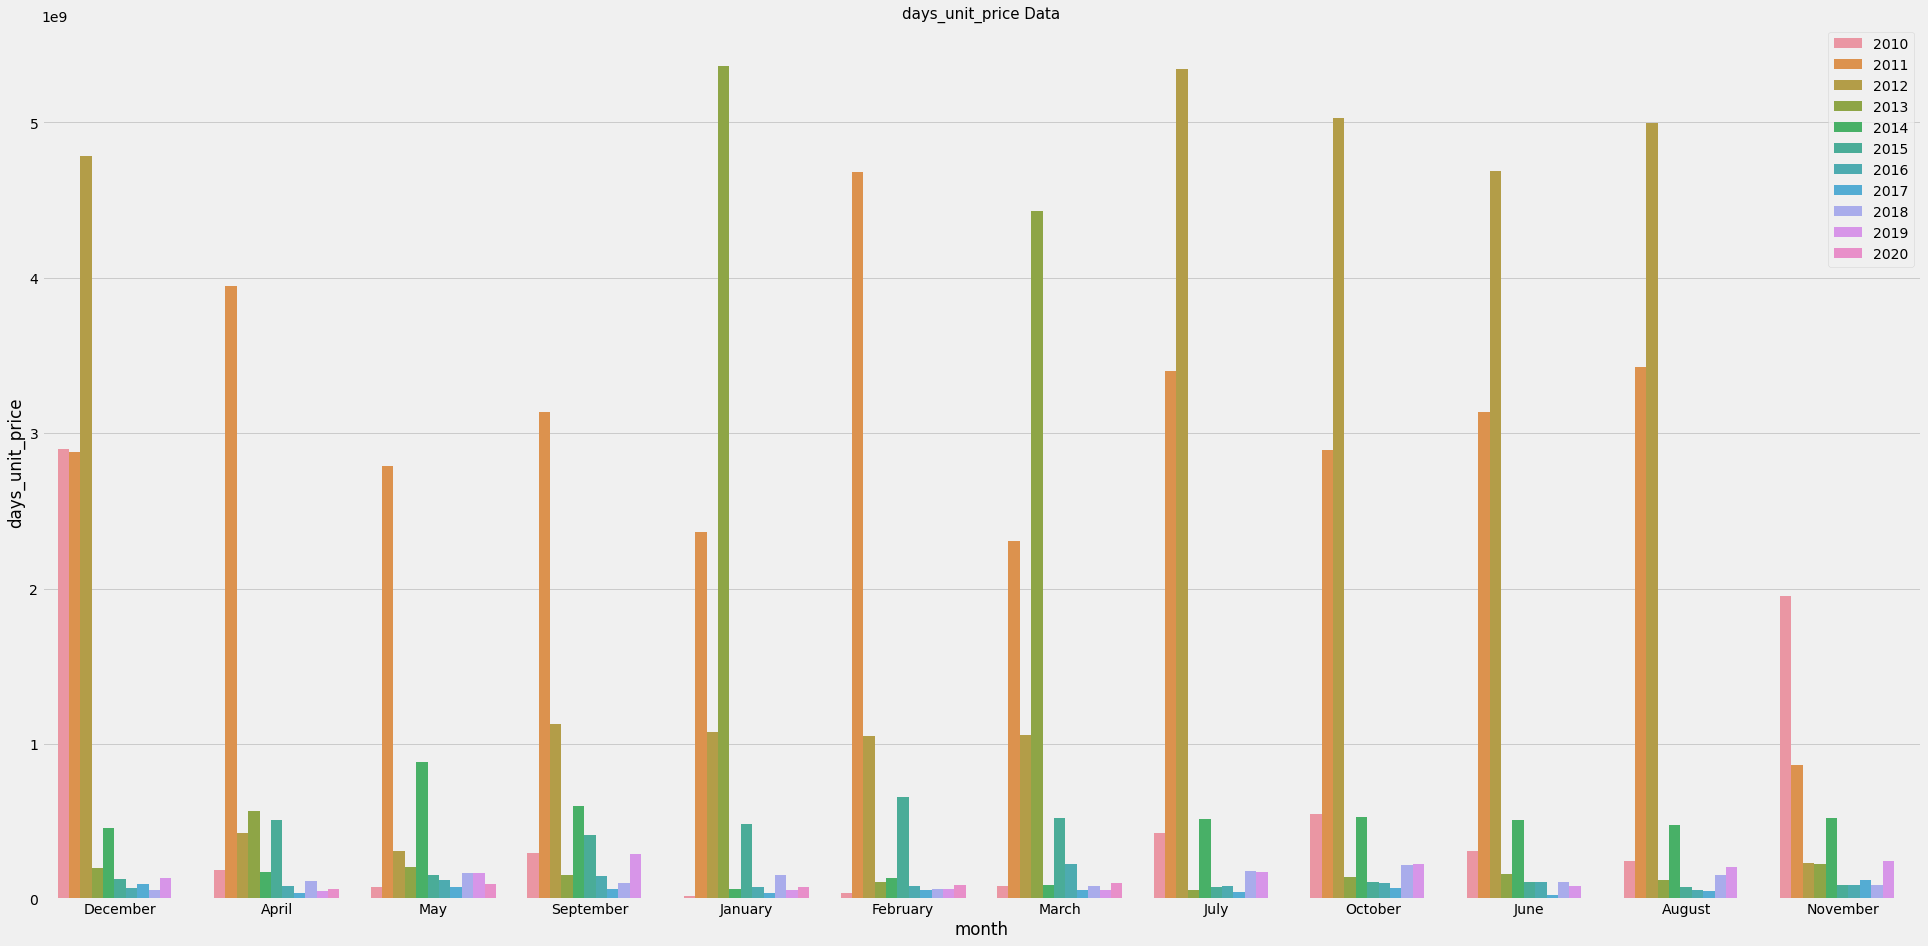

In [20]:
fig, ax = plt.subplots(figsize=(30, 15))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="month", y="days_unit_price", hue="year", data=df_new, ci=None)
a.set_title("days_unit_price Data", fontsize=15)
plt.legend(loc="upper right")
plt.show()

Text(0.5, 1.0, 'Total unit_price received By year')

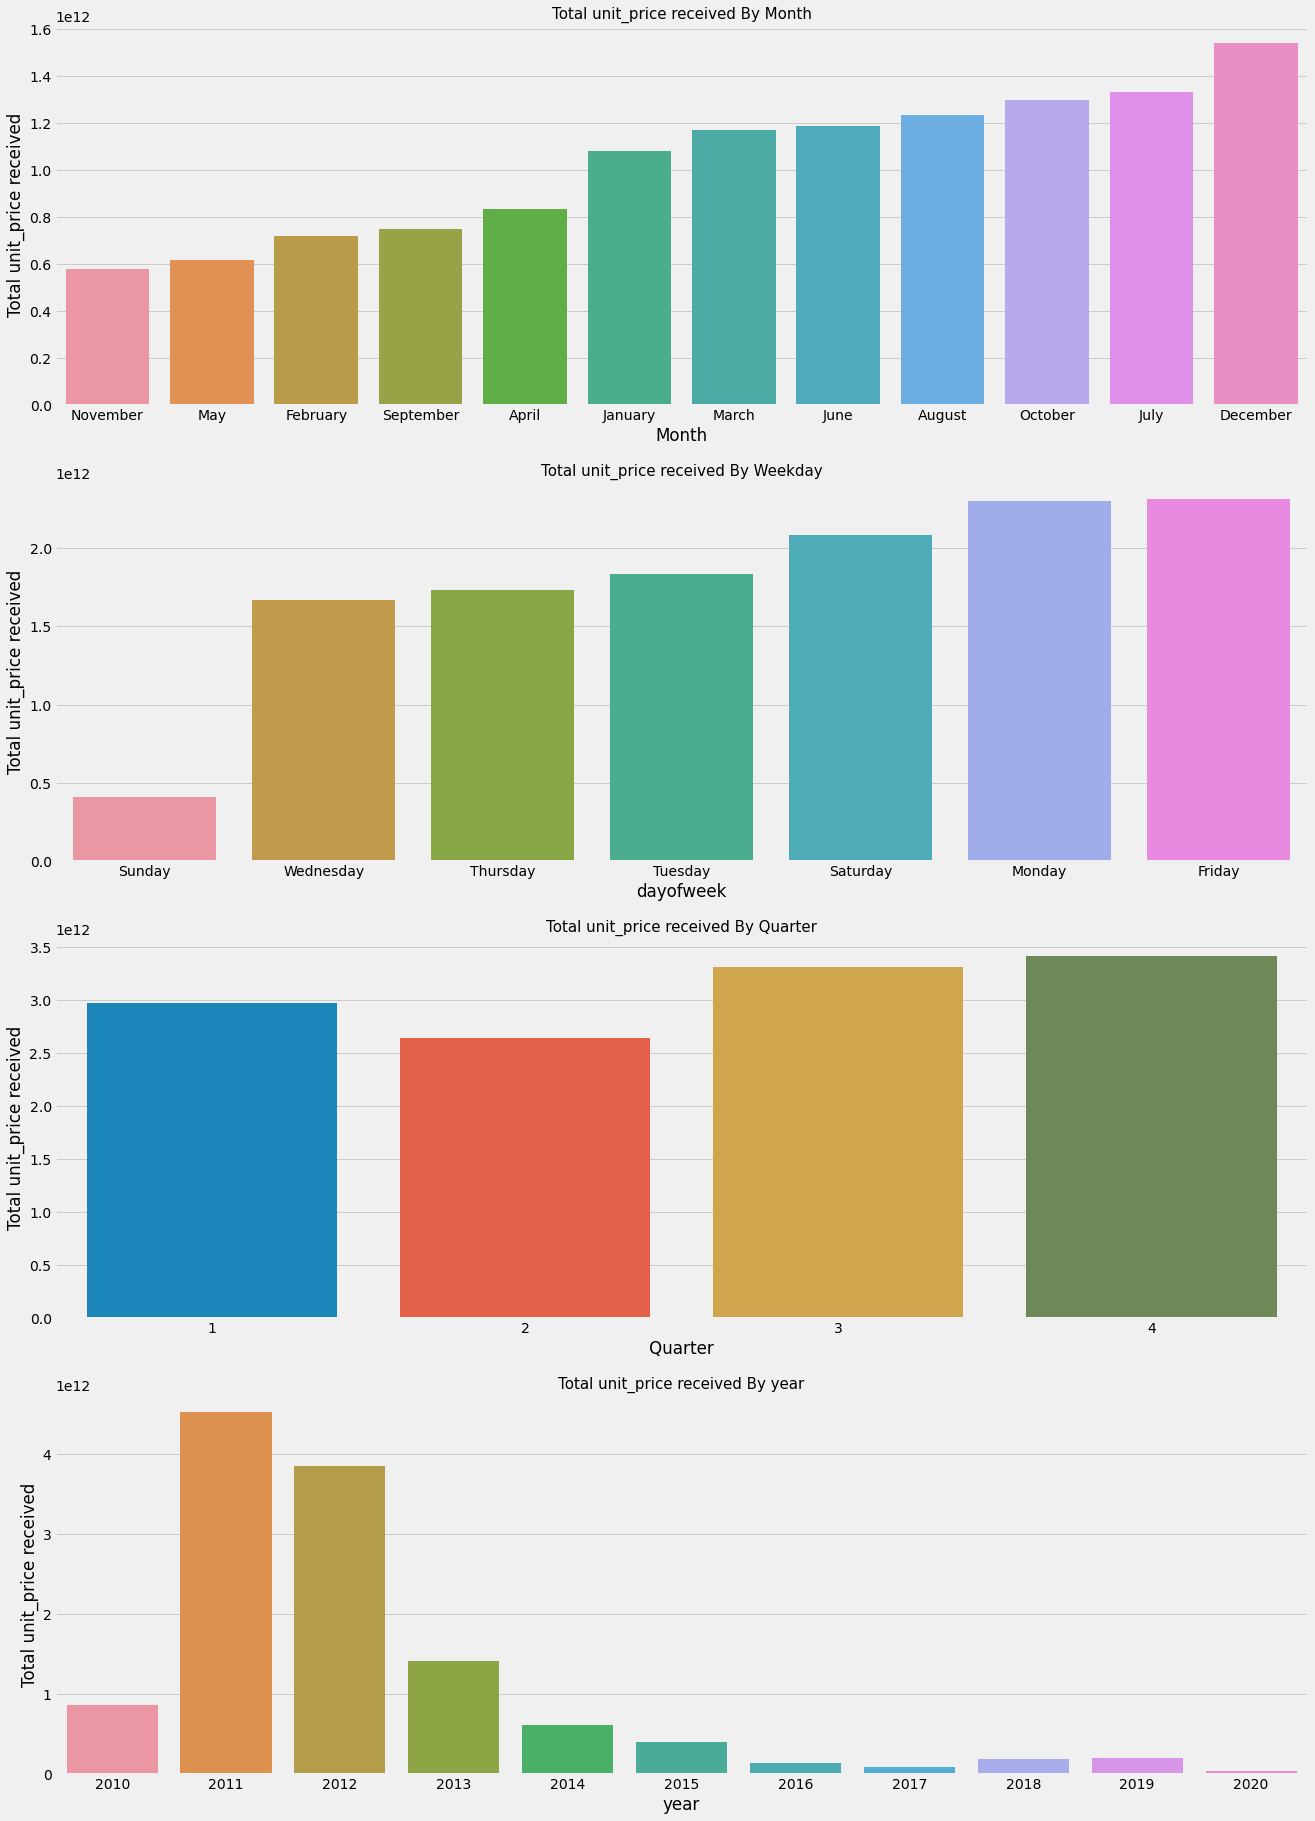

In [21]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["days_unit_price"].sum()).reset_index().sort_values('days_unit_price')
sns.barplot(data=monthAggregated,x="month",y="days_unit_price",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total unit_price received')
ax1.set_title("Total unit_price received By Month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["days_unit_price"].sum()).reset_index().sort_values('days_unit_price')
sns.barplot(data=monthAggregated,x="dayofweek",y="days_unit_price",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total unit_price received')
ax2.set_title("Total unit_price received By Weekday",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["days_unit_price"].sum()).reset_index().sort_values('days_unit_price')
sns.barplot(data=monthAggregated,x="quarter",y="days_unit_price",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total unit_price received')
ax3.set_title("Total unit_price received By Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["days_unit_price"].sum()).reset_index().sort_values('days_unit_price')
sns.barplot(data=monthAggregated,x="year",y="days_unit_price",ax=ax4)
ax4.set(xlabel='year', ylabel='Total unit_price received')
ax4.set_title("Total unit_price received By year",fontsize=15)

## Month 기준 Forecast

In [22]:
df = df.resample("M").sum()
df = df.drop(["days_ap_kor_amt", "days_unit_ap_qty", "incremental_number"], axis=1)
df.reset_index(inplace=True)
df.head()

,timestamp,days_unit_price
0,2010-01-31,1512993238
1,2010-02-28,3686241598
2,2010-03-31,9139322316
3,2010-04-30,20647841727
4,2010-05-31,8123167024


In [25]:
df=df.rename(columns={'timestamp':'ds','days_unit_price':'y'})

print(f"y_max : {df['y'].max()}, y_min : {df['y'].min()}")

y_max : 689188138818, y_min : 4250


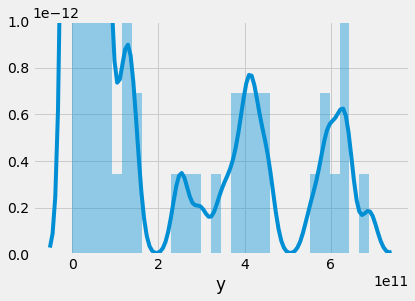

In [26]:
sns.distplot(df["y"])

In [27]:
primal_date = '2019-8-31'
end_date = '2020-03-01'
mask1 = (df['ds'] <= primal_date)
mask2 = (df['ds'] > primal_date)
mask3 = (df['ds'] < end_date)

In [28]:
X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
X_tst = X_tst.loc[mask3]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (116, 2)
test shape (6, 2)


In [29]:
X_tst.tail(10)

,ds,y
116,2019-09-30,25722867177
117,2019-10-31,24328070879
118,2019-11-30,31119390229
119,2019-12-31,16204543364
120,2020-01-31,7968692468
121,2020-02-29,9166533544


In [30]:
X_tr.describe()

,y
count,1.160000e+02
mean,1.051303e+11
std,1.785267e+11
min,1.512993e+09
25%,9.710676e+09
50%,2.055741e+10
75%,6.975434e+10
max,6.891881e+11


In [31]:
X_tst.describe()

,y
count,6.000000e+00
mean,1.908502e+10
std,9.451168e+09
min,7.968692e+09
25%,1.092604e+10
50%,2.026631e+10
75%,2.537417e+10
max,3.111939e+10


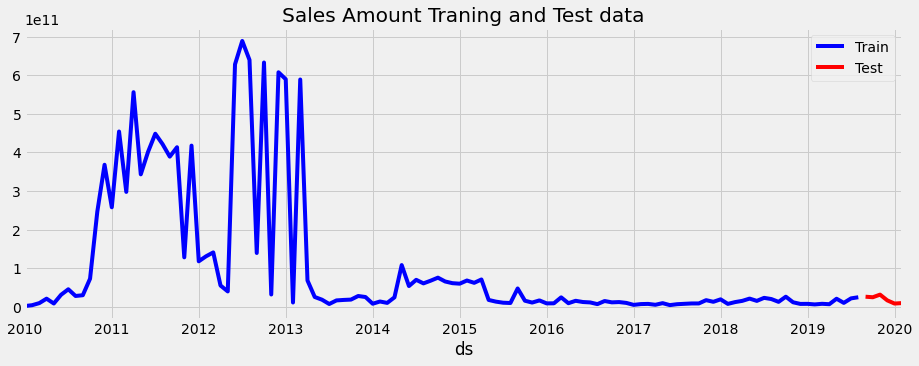

In [32]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_tr.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_tst.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Sales Amount Traning and Test data')
plt.show()

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Simple Prophet Model

In [34]:
X_tr.head()

,ds,y
0,2010-01-31,1512993238
1,2010-02-28,3686241598
2,2010-03-31,9139322316
3,2010-04-30,20647841727
4,2010-05-31,8123167024


In [35]:
X_tst.tail(20)

,ds,y
116,2019-09-30,25722867177
117,2019-10-31,24328070879
118,2019-11-30,31119390229
119,2019-12-31,16204543364
120,2020-01-31,7968692468
121,2020-02-29,9166533544


In [36]:
model = Prophet()
model.fit(X_tr)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future = model.make_future_dataframe(periods=6, freq="M")
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(7)

,ds,yhat,yhat_lower,yhat_upper
115,2019-08-31,-1.566327e+10,-2.020054e+11,1.790178e+11
116,2019-09-30,-6.360534e+10,-2.609582e+11,1.361852e+11
117,2019-10-31,-9.282308e+09,-1.986946e+11,1.929242e+11
118,2019-11-30,-8.354857e+10,-2.781362e+11,1.118984e+11
119,2019-12-31,1.846356e+10,-1.848121e+11,2.088774e+11
120,2020-01-31,-6.552850e+10,-2.462682e+11,1.131264e+11
121,2020-02-29,-9.998907e+10,-3.030952e+11,9.733005e+10


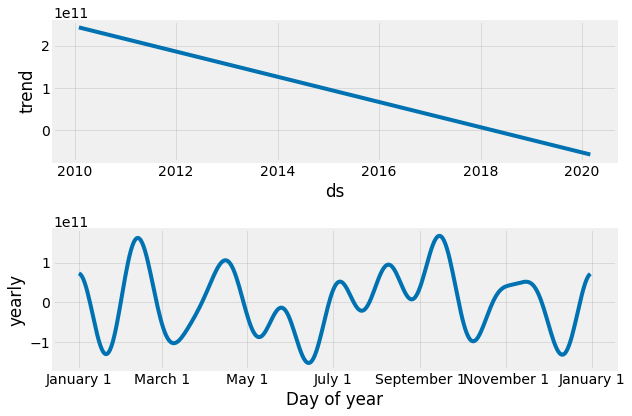

In [38]:
fig = model.plot_components(forecast)

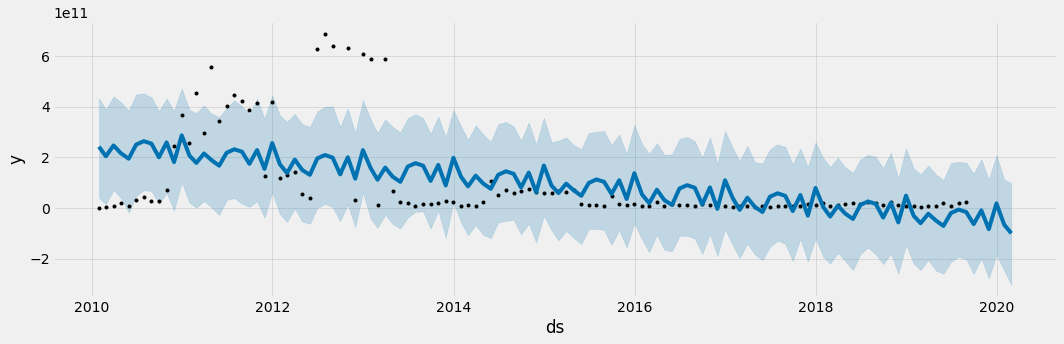

In [39]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

## Actual vs Prediction Comparison

In [40]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-30,-6.360534e+10,-2.597653e+11,1.305363e+11
1,2019-10-31,-9.282308e+09,-1.977334e+11,1.688658e+11
2,2019-11-30,-8.354857e+10,-2.793069e+11,9.674650e+10
3,2019-12-31,1.846356e+10,-1.766442e+11,2.139989e+11
4,2020-01-31,-6.552850e+10,-2.517593e+11,1.332612e+11
5,2020-02-29,-9.998907e+10,-2.912931e+11,9.673546e+10


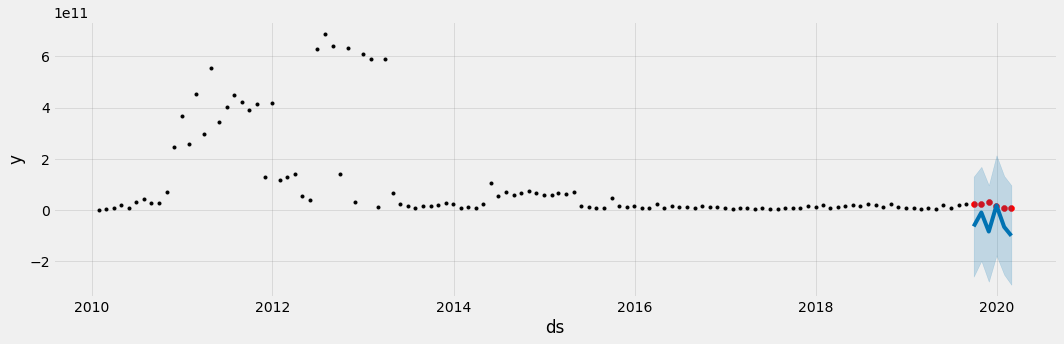

In [41]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)

## 3.2 Compare the test Sales and forecasted Sales

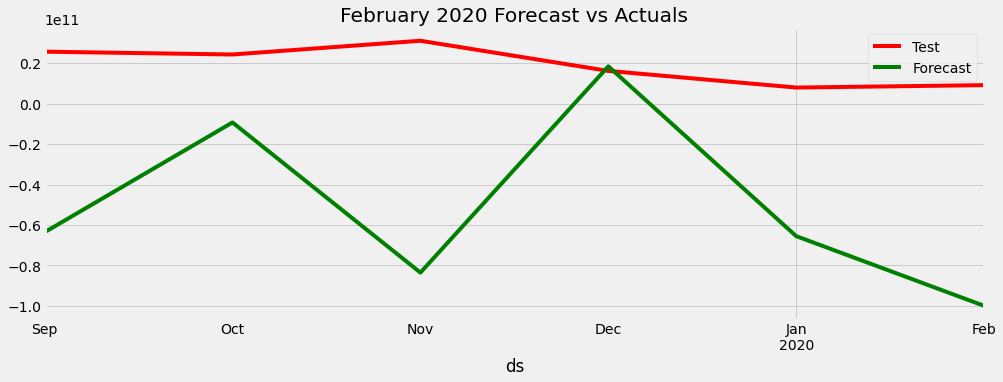

In [42]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

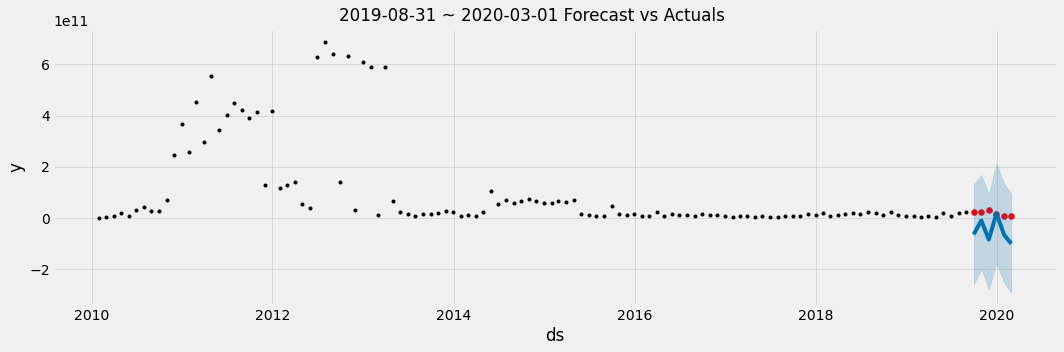

In [43]:
import datetime

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(X_tst.ds, X_tst['y'], color='r')
fig = model.plot(X_tst_forecast, ax=ax)
# ax.set_xlim([datetime.date(2019, 9, 15), datetime.date(2020, 3, 1)])
# ax.set_ylim(-300000000000, 300000000000)
# ax.set_ylim(-1, 4)
plot = plt.suptitle('2019-08-31 ~ 2020-03-01 Forecast vs Actuals')

In [44]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 496.8291


# 4. HyperParameter Tuning using ParameterGrid

In [45]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
               'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)

cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 30


In [46]:
strt = '2019-8-31'
end = '2020-03-01'

model_parameters = pd.DataFrame(columns = ["MAPE", "Parameters"])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True, 
                         interval_width=0.95)
    
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=6, freq='M',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mean_absolute_percentage_error(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 52.479980592502514
{'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 293.3940057952141
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 52.479980592502514
{'changepoint_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 293.3940057952141
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 52.479980592502514
{'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 293.3940057952141
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.54624881493805
{'changepoint_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 417.3054985768272
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.54624881493805
{'changepoint_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 417.3054985768272
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 79.54624881493805
{'changepoint_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 417.3054985768272
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 89.41165163243011
{'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 446.85056621586546
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 89.41165163243011
{'changepoint_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 446.85056621586546
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 89.41165163243011
{'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 446.85056621586546
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 96.33982192402839
{'changepoint_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 437.46629772414246
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 96.33982192402839
{'changepoint_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 437.46629772414246
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 96.33982192402839
{'changepoint_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 437.46629772414246
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 99.22662819247427
{'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 445.4281735306043
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 99.22662819247427
{'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 445.4281735306043
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


Mean Absolute Percentage Error(MAPE)------------------------------------ 99.22662819247427
{'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 445.4281735306043


In [47]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,52.479981,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
1,52.479981,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
2,52.479981,"{'changepoint_prior_scale': 0.1, 'n_changepoin..."
3,79.546249,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."
4,79.546249,"{'changepoint_prior_scale': 0.2, 'n_changepoin..."


In [48]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [49]:
# Setup and train model with holidays
final_model = Prophet(changepoint_prior_scale= 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'multiplicative')
final_model.fit(X_tr)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 91.


In [50]:
future = final_model.make_future_dataframe(periods=6, freq='M')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
115,2019-08-31,-5.771031e+10,-2.457978e+11,1.204488e+11
116,2019-09-30,-3.199666e+10,-2.183979e+11,1.505901e+11
117,2019-10-31,-7.037263e+10,-2.616685e+11,9.701584e+10
118,2019-11-30,-2.789818e+10,-2.107625e+11,1.616353e+11
119,2019-12-31,-1.050478e+11,-2.823020e+11,7.533828e+10
120,2020-01-31,-5.637274e+10,-2.440918e+11,1.269633e+11
121,2020-02-29,-4.075105e+10,-2.213909e+11,1.385185e+11


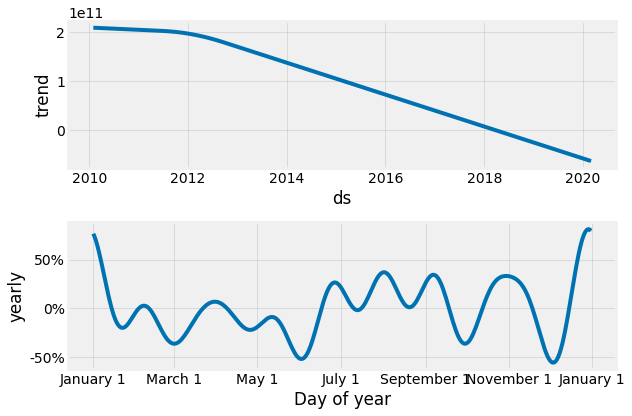

In [51]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

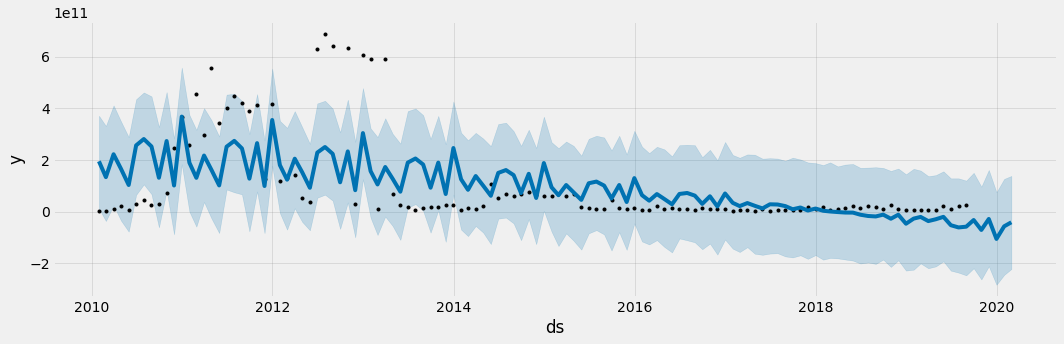

In [52]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_model.plot(forecast,ax=ax)
plt.show()

### Final model : Test

In [53]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-30,-3.199666e+10,-2.213597e+11,1.520474e+11
1,2019-10-31,-7.037263e+10,-2.511381e+11,1.173804e+11
2,2019-11-30,-2.789818e+10,-2.050262e+11,1.614956e+11
3,2019-12-31,-1.050478e+11,-2.981132e+11,6.699648e+10
4,2020-01-31,-5.637274e+10,-2.434628e+11,1.432936e+11
5,2020-02-29,-4.075105e+10,-2.223431e+11,1.355242e+11


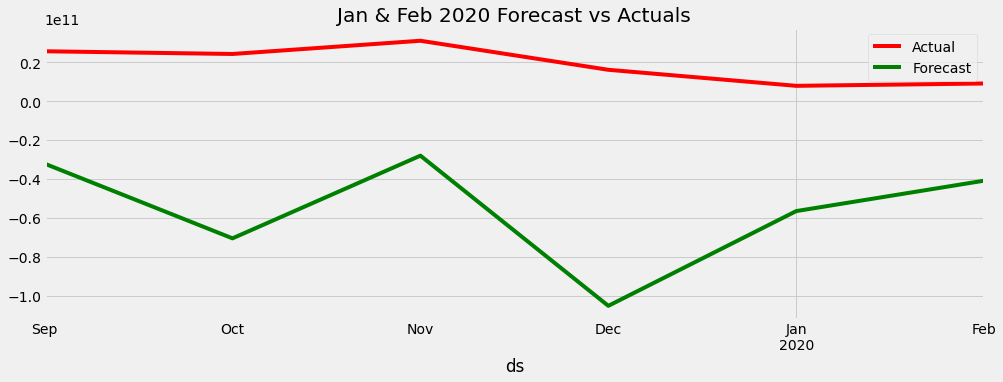

In [54]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Jan & Feb 2020 Forecast vs Actuals')
plt.show()

In [55]:
MAPE = mean_absolute_percentage_error(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 287.3764425076486


In [58]:
df.to_csv("/gdrive/My Drive/colab/Sale_data/dataset/final/preprocessed_data.csv")

In [59]:
forecast.to_csv("/gdrive/My Drive/colab/Sale_data/dataset/final/forecast_train.csv")

In [60]:
X_tst_final.to_csv("/gdrive/My Drive/colab/Sale_data/dataset/final/forecast_test_result.csv")